In [1]:
!pip3 install typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=c9f1e7d43d1ca6186ccffd4efca14181bff28f65d4a6c74491fc392cf3c942ea
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


The code in below sections are from weighted naive bayes library on github: https://github.com/msamsami/weighted-naive-bayes

This library was copied and modified for unbalanced class cases.

In [3]:
from enum import EnumMeta, Enum
from typing import Any


class CaseInsensitiveEnumMeta(EnumMeta):
    """
    Enum metaclass to allow for interoperability with case-insensitive strings.
    """

    def __getitem__(cls, name: str) -> Any:
        return super(CaseInsensitiveEnumMeta, cls).__getitem__(name.upper())

    def __getattr__(cls, name: str) -> Enum:
        """Returns the enum member matching `name`.

        We use __getattr__ instead of descriptors or inserting into the enum
        class' __dict__ in order to support `name` and `value` being both
        properties for enum members (which live in the class' __dict__) and
        enum members themselves.

        :param str name: The name of the enum member to retrieve.
        :rtype: ~CaseInsensitiveEnumMeta
        :return: The enum member matching `name`.
        :raises AttributeError: If `name` is not a valid enum member.
        """
        try:
            return cls._member_map_[name.upper()]
        except KeyError as err:
            raise AttributeError(name) from err

In [4]:
from enum import Enum

__all__ = ["Distribution"]


class Distribution(str, Enum, metaclass=CaseInsensitiveEnumMeta):
    """
    Names of probability distributions.
    """

    NORMAL = "Normal"
    LOGNORMAL = "Lognormal"
    EXPONENTIAL = "Exponential"
    UNIFORM = "Uniform"
    PARETO = "Pareto"
    GAMMA = "Gamma"
    BETA = "Beta"
    CHI_SQUARED = "Chi-squared"
    BERNOULLI = "Bernoulli"
    CATEGORICAL = "Categorical"
    GEOMETRIC = "Geometric"
    POISSON = "Poisson"

In [5]:
from abc import ABCMeta
from functools import wraps
import inspect
from numbers import Number
from typing import List, Tuple, Union
import warnings

import numpy as np

__all__ = ["ContinuousDistMixin", "DiscreteDistMixin"]


def vectorize(otypes=None, excluded=None, signature=None):
    """
    Numpy vectorization wrapper that works with class methods.
    """

    def decorator(func):
        vectorized = np.vectorize(
            func, otypes=otypes, excluded=excluded, signature=signature
        )

        @wraps(func)
        def wrapper(*args):
            return vectorized(*args)

        return wrapper

    return decorator


class DistMixin(metaclass=ABCMeta):
    """
    Mixin class for probability distributions in wnb.
    """

    name: Union[str, Distribution]
    _support: Union[List[float], Tuple[float, float]]

    @classmethod
    def from_data(cls, data, **kwargs):
        """Creates an instance of the class from given data. Distribution parameters will be estimated from data.

        Args:
            data: Input data from which distribution parameters will be estimated.

        Returns:
            self: An instance of the class.
        """
        pass

    @classmethod
    def _get_param_names(cls):
        """
        Gets parameter names for the distribution instance.
        """
        init = getattr(cls.__init__, "deprecated_original", cls.__init__)
        if init is object.__init__:
            return []

        init_signature = inspect.signature(init)
        parameters = [
            p
            for p in init_signature.parameters.values()
            if p.name != "self" and p.kind != p.VAR_KEYWORD
        ]

        for p in parameters:
            if p.kind == p.VAR_POSITIONAL:
                raise RuntimeError(
                    "wnb estimators should always "
                    "specify their parameters in the signature "
                    "of their __init__ (no varargs). "
                    "%s with constructor %s doesn't "
                    "follow this convention." % (cls, init_signature)
                )

        return sorted([p.name for p in parameters])

    def get_params(self) -> dict:
        """Gets parameters for this distribution instance.

        Returns:
            dict: Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            out[key] = value
        return out

    @property
    def support(self) -> Union[List[float], Tuple[float, float]]:
        """Returns the support of the probability distribution.

        If support is a list, it represents a limited number of discrete values.
        If it is a tuple, it indicates a limited or unlimited range of continuous values.
        """
        return self._support

    def _check_support(self, x):
        if (isinstance(self.support, list) and x not in self.support) or (
            isinstance(self.support, tuple)
            and (x < self.support[0] or x > self.support[1])
        ):
            warnings.warn(
                "Value doesn't lie within the support of the distribution",
                RuntimeWarning,
            )

    def __repr__(self) -> str:
        return "".join(
            [
                "<",
                self.__class__.__name__,
                "(",
                ", ".join(
                    [
                        f"{k}={v:.4f}" if isinstance(v, Number) else f"{k}={v}"
                        for k, v in self.get_params().items()
                    ]
                ),
                ")>",
            ]
        )


class ContinuousDistMixin(DistMixin, metaclass=ABCMeta):
    """
    Mixin class for all continuous probability distributions in wnb.
    """

    _type = "continuous"

    def __init__(self, **kwargs):
        """
        Initializes an instance of the continuous probability distribution with given parameters.
        """
        pass

    def pdf(self, x: float) -> float:
        """Returns the value of probability density function (PDF) at x.

        Args:
            x (float): Input value.

        Returns:
            float: Probability density.
        """
        pass

    @vectorize(signature="(),()->()")
    def __call__(self, x: float) -> float:
        self._check_support(x)
        return self.pdf(x)


class DiscreteDistMixin(DistMixin, metaclass=ABCMeta):
    """
    Mixin class for all discrete probability distributions in wnb.
    """

    _type = "discrete"

    def __init__(self, **kwargs):
        """
        Initializes an instance of the discrete probability distribution with given parameters.
        """
        pass

    def pmf(self, x: float) -> float:
        """Returns the value of probability mass function (PMF) at x.

        Args:
            x (float): Input value.

        Returns:
            float: Probability mass.
        """
        pass

    @vectorize(signature="(),()->()")
    def __call__(self, x: float) -> float:
        self._check_support(x)
        return self.pmf(x)

In [6]:
from typing import Union, Type

import numpy.typing
import numpy as np
import pandas as pd
from scipy.sparse import spmatrix

__all__ = ["MatrixLike", "ArrayLike", "Int", "Float", "DistibutionLike"]

ArrayLike = numpy.typing.ArrayLike
MatrixLike = Union[np.ndarray, pd.DataFrame, spmatrix]

Int = Union[int, np.int8, np.int16, np.int32, np.int64]
Float = Union[float, np.float16, np.float32, np.float64]

DistibutionLike = Union[
    str,
    Distribution,
    Type[ContinuousDistMixin],
    Type[DiscreteDistMixin],
]

In [7]:
from abc import ABCMeta
import numbers
from typing import Optional
import warnings

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import logsumexp

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import DataConversionWarning
from sklearn.utils import as_float_array, check_array, deprecated
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import type_of_target, check_classification_targets


__all__ = [
    "GaussianWNB",
]


class GaussianWNB(ClassifierMixin, BaseEstimator, metaclass=ABCMeta):
    """Binary Gaussian Minimum Log-likelihood Difference Weighted Naive Bayes (MLD-WNB) classifier

    Parameters
    ----------
    priors : array-like of shape (n_classes,), default=None
        Prior probabilities of the classes. If specified, the priors are not
        adjusted according to the data.
    error_weights : array-like of shape (n_classes, n_classes), default=None
        Matrix of error weights. If not specified, equal weight is assigned to the
        errors of both classes.
    max_iter : int, default=25
        Maximum number of gradient descent iterations.
    step_size : float, default=1e-4
        Step size of weight update (i.e., learning rate).
    penalty : str, default="l2"
        Regularization term, either 'l1' or 'l2'.
    C : float, default=1.0
        Regularization strength. Must be strictly positive.
    learning_hist : bool, default=False
        Whether to record the learning history, i.e., the value of cost function
        in each learning iteration.

    Attributes
    ----------
    class_count_ : ndarray of shape (n_classes,)
        Number of training samples observed in each class.

    class_prior_ : ndarray of shape (n_classes,)
        Probability of each class.

    classes_ : ndarray of shape (n_classes,)
        Class labels known to the classifier.

    n_classes_ : int
        Number of classes seen during :term:`fit`.

    n_features_in_ : int
        Number of features seen during :term:`fit`.

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.

    error_weights_ : ndarray of shape (n_classes, n_classes)
        Specified matrix of error weights.

    theta_ : ndarray of shape (n_features, n_classes)
        Mean of each feature per class.

    std_ : ndarray of shape (n_features, n_classes)
        Standard deviation of each feature per class.

    var_ : ndarray of shape (n_features, n_classes)
        Variance of each feature per class.

    coef_ : ndarray of shape (n_features,)
        Weights assigned to the features.

    cost_hist_ : ndarray of shape (max_iter,)
        Cost value in each iteration of the optimization.

    n_iter_ : int
        Number of iterations run by the optimization routine to fit the model.
    """

    class_count_: np.ndarray
    class_prior_: np.ndarray
    classes_: np.ndarray
    n_classes_: int
    n_features_in_: int
    feature_names_in_: np.ndarray
    error_weights_: np.ndarray
    theta_: np.ndarray
    std_: np.ndarray
    var_: np.ndarray
    coef_: np.ndarray
    cost_hist_: np.ndarray
    n_iter_: int

    def __init__(
        self,
        *,
        priors: Optional[ArrayLike] = None,
        error_weights: Optional[np.ndarray] = None,
        max_iter: Int = 25,
        step_size: Float = 1e-4,
        penalty: str = "l2",
        C: Float = 1.0,
        learning_hist: bool = False
    ) -> None:
        self.priors = priors
        self.error_weights = error_weights
        self.max_iter = max_iter
        self.step_size = step_size
        self.penalty = penalty
        self.C = C
        self.learning_hist = learning_hist

    def _more_tags(self):
        return {"binary_only": True, "requires_y": True}

    def _check_inputs(self, X, y):
        # Check if the targets are suitable for classification
        check_classification_targets(y)

        # Check that the dataset has only two unique labels
        if type_of_target(y) != "binary":
            warnings.warn(
                "This version of MLD-WNB only supports binary classification."
            )
            raise ValueError("Unknown label type: non-binary")

        # Check if only one class is present in label vector
        if self.n_classes_ == 1:
            raise ValueError("Classifier can't train when only one class is present.")

        X = check_array(
            array=X,
            accept_sparse=False,
            accept_large_sparse=False,
            dtype="numeric",
            force_all_finite=True,
            ensure_2d=True,
            ensure_min_samples=1,
            ensure_min_features=1,
            estimator=self,
        )

        # Check if X contains complex values
        if np.iscomplex(X).any() or np.iscomplex(y).any():
            raise ValueError("Complex data not supported")

        # Check that the number of samples and labels are compatible
        if self.__n_samples != y.shape[0]:
            raise ValueError(
                "X.shape[0]=%d and y.shape[0]=%d are incompatible."
                % (X.shape[0], y.shape[0])
            )

        if self.priors is not None:
            # Check that the provided priors match the number of classes
            if len(self.priors) != self.n_classes_:
                raise ValueError("Number of priors must match the number of classes.")
            # Check that the sum of priors is 1
            if not np.isclose(self.priors.sum(), 1.0):
                raise ValueError("The sum of the priors should be 1.")
            # Check that the priors are non-negative
            if (self.priors < 0).any():
                raise ValueError("Priors must be non-negative.")

        if self.error_weights is not None:
            # Check that the size of error weights matrix matches number of classes
            if self.error_weights.shape != (self.n_classes_, self.n_classes_):
                raise ValueError(
                    "The shape of error weights matrix does not match the number of classes, "
                    "must be (n_classes, n_classes)."
                )

        # Check that the regularization type is either 'l1' or 'l2'
        if self.penalty not in ["l1", "l2"]:
            raise ValueError("Regularization type must be either 'l1' or 'l2'.")

        # Check that the regularization parameter is a positive integer
        if not isinstance(self.C, numbers.Number) or self.C < 0:
            raise ValueError(
                "Regularization parameter must be positive; got (C=%r)" % self.C
            )

        # Check that the maximum number of iterations is a positive integer
        if not isinstance(self.max_iter, numbers.Number) or self.max_iter < 0:
            raise ValueError(
                "Maximum number of iteration must be a positive integer; got (max_iter=%r)."
                % self.max_iter
            )

    def _prepare_X_y(self, X=None, y=None, from_fit=False):
        if from_fit and y is None:
            raise ValueError("requires y to be passed, but the target y is None.")

        if X is not None:
            # Convert to NumPy array if X is Pandas DataFrame
            if isinstance(X, pd.DataFrame):
                X = X.values
            X = as_float_array(X)

        if y is not None:
            # Convert to a NumPy array
            if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
                y = y.values
            else:
                y = np.array(y)

            # Warning in case of y being 2d
            if y.ndim > 1:
                warnings.warn(
                    "A column-vector y was passed when a 1d array was expected.",
                    DataConversionWarning,
                )

            y = y.flatten()

        output = tuple(item for item in [X, y] if item is not None)
        return output[0] if len(output) == 1 else output

    def _prepare_parameters(self, X, y):
        # Calculate mean and standard deviation of features for each class
        for c in range(self.n_classes_):
            self.theta_[:, c] = np.mean(
                X[y == c, :], axis=0
            )  # Calculate mean of features for class c
            self.std_[:, c] = np.std(
                X[y == c, :], axis=0
            )  # Calculate std of features for class c
        self.var_ = np.square(self.std_)  # Calculate variance of features using std

        # Update if no priors is provided
        if self.priors is None:
            self.class_prior_ = (
                self.class_count_ / self.class_count_.sum()
            )  # Calculate empirical prior probabilities
        else:
            self.class_prior_ = self.priors

        # Convert to NumPy array if input priors is in a list
        if type(self.class_prior_) is list:
            self.class_prior_ = np.array(self.class_prior_)

        # Update if no error weights is provided
        if self.error_weights is None:
            self.error_weights_ = np.array([[0, 1], [-1, 0]])
        else:
            self.error_weights_ = self.error_weights

    def fit(self, X: MatrixLike, y: ArrayLike):
        """Fits Gaussian Binary MLD-WNB classifier according to X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self._check_n_features(X=X, reset=True)
        self._check_feature_names(X=X, reset=True)

        X, y = self._prepare_X_y(X, y, from_fit=True)

        self.classes_, y_, self.class_count_ = np.unique(
            y, return_counts=True, return_inverse=True
        )  # Unique class labels, their indices, and class counts
        self.n_classes_ = len(self.classes_)  # Number of classes

        self.__n_samples = X.shape[0]  # Number of samples (for internal use)

        self._check_inputs(X, y)
        y = y_

        self.theta_ = np.zeros(
            (self.n_features_in_, self.n_classes_)
        )  # Mean of each feature per class (n_features x n_classes)
        self.std_ = np.zeros(
            (self.n_features_in_, self.n_classes_)
        )  # Standard deviation of each feature per class (n_features x n_classes)
        self.var_ = np.zeros(
            (self.n_features_in_, self.n_classes_)
        )  # Variance of each feature per class (n_features x n_classes)
        self.coef_ = np.ones(
            (self.n_features_in_,)
        )  # WNB coefficients (n_features x 1)
        self.cost_hist_ = np.array(
            [np.nan for _ in range(self.max_iter)]
        )  # Cost value in each iteration

        self._prepare_parameters(X, y)

        # Learn the weights using gradient descent
        self.n_iter_ = 0
        for self.n_iter_ in range(self.max_iter):
            # Predict on X
            y_hat = self.__predict(X)

            # Calculate cost
            self.cost_hist_[self.n_iter_], _lambda = self._calculate_cost(
                X, y, y_hat, self.learning_hist
            )

            # Calculate gradients (most time-consuming)
            _grad = self._calculate_grad(X, _lambda)

            # Add regularization
            if self.penalty == "l1":
                _grad += self.C * np.sign(self.coef_)
            elif self.penalty == "l2":
                _grad += 2 * self.C * self.coef_

            # Update weights
            self.coef_ = self.coef_ - self.step_size * _grad

        self.n_iter_ += 1
        self.cost_hist_ = None if not self.learning_hist else self.cost_hist_

        return self

    def _calculate_cost(self, X, y, y_hat, learning_hist):
        _lambda = [self.error_weights_[y[i], y_hat[i]] for i in range(self.__n_samples)]

        if learning_hist:
            # Calculate cost
            _cost = 0
            for i in range(self.__n_samples):
                _sum = np.log(self.class_prior_[1] / self.class_prior_[0])
                x = X[i, :]
                for j in range(self.n_features_in_):
                    _sum += self.coef_[j] * (
                        np.log(
                            1e-20 + norm.pdf(x[j], self.theta_[j, 1], self.std_[j, 1])
                        )
                        - np.log(
                            1e-20 + norm.pdf(x[j], self.theta_[j, 0], self.std_[j, 0])
                        )
                    )
                _cost += _lambda[i] * _sum
        else:
            _cost = np.nan

        return _cost, _lambda

    def _calculate_grad(self, X, _lambda):
        _grad = np.repeat(
            np.log(self.std_[:, 0] / self.std_[:, 1]).reshape(1, -1),
            self.__n_samples,
            axis=0,
        )
        _grad += (
            0.5
            * (
                (
                    X
                    - np.repeat(
                        self.theta_[:, 0].reshape(1, -1), self.__n_samples, axis=0
                    )
                )
                / (np.repeat(self.std_[:, 0].reshape(1, -1), self.__n_samples, axis=0))
            )
            ** 2
        )
        _grad -= (
            0.5
            * (
                (
                    X
                    - np.repeat(
                        self.theta_[:, 1].reshape(1, -1), self.__n_samples, axis=0
                    )
                )
                / (np.repeat(self.std_[:, 1].reshape(1, -1), self.__n_samples, axis=0))
            )
            ** 2
        )
        _grad *= np.transpose(
            np.repeat(np.array(_lambda).reshape(1, -1), self.n_features_in_, axis=0)
        )
        _grad = np.sum(_grad, axis=0)

        return _grad

    @deprecated()
    def _calculate_grad_slow(self, X, _lambda):
        _grad = np.zeros((self.n_features_in_,))
        for i in range(self.__n_samples):
            x = X[i, :]
            _log_p = np.array(
                [
                    np.log(self.std_[j, 0] / self.std_[j, 1])
                    + 0.5 * ((x[j] - self.theta_[j, 0]) / self.std_[j, 0]) ** 2
                    - 0.5 * ((x[j] - self.theta_[j, 1]) / self.std_[j, 1]) ** 2
                    for j in range(self.n_features_in_)
                ]
            )
            _grad += _lambda[i] * _log_p
        return _grad

    def __predict(self, X):
        p_hat = self.predict_log_proba(X)
        return np.argmax(p_hat, axis=1)

    def predict(self, X: MatrixLike) -> np.ndarray:
        """Performs classification on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        C : ndarray of shape (n_samples,)
            Predicted target values for X.
        """
        p_hat = self.predict_log_proba(X)
        y_hat = self.classes_[np.argmax(p_hat, axis=1)]
        return y_hat

    def predict_log_proba(self, X: MatrixLike) -> np.ndarray:
        """Returns log-probability estimates for the array of test vectors X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        C : array-like of shape (n_samples, n_classes)
            Returns the log-probability of the samples for each class in
            the model. The columns correspond to the classes in sorted
            order, as they appear in the attribute :term:`classes_`.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(
            array=X, accept_large_sparse=False, force_all_finite=True, estimator=self
        )

        # Check if the number of input features matches the data seen during fit
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                "Expected input with %d features, got %d instead."
                % (self.n_features_in_, X.shape[1])
            )

        n_samples = X.shape[0]

        X = self._prepare_X_y(X=X)

        log_priors = np.tile(np.log(self.class_prior_), (n_samples, 1))
        w_reshaped = np.tile(self.coef_.reshape(-1, 1), (1, self.n_classes_))
        term1 = np.sum(np.multiply(w_reshaped, -np.log(np.sqrt(2 * np.pi) * self.std_)))
        var_inv = np.multiply(w_reshaped, 1.0 / np.multiply(self.std_, self.std_))
        mu_by_var = np.multiply(self.theta_, var_inv)
        term2 = -0.5 * (
            np.matmul(np.multiply(X, X), var_inv)
            - 2.0 * np.matmul(X, mu_by_var)
            + np.sum(self.theta_.conj() * mu_by_var, axis=0)
        )
        log_proba = log_priors + term1 + term2

        log_proba -= np.transpose(
            np.repeat(
                logsumexp(log_proba, axis=1).reshape(1, -1), self.n_classes_, axis=0
            )
        )
        return log_proba

    def predict_proba(self, X: MatrixLike) -> np.ndarray:
        """Returns probability estimates for the array of test vectors X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.

        Returns
        -------
        C : array-like of shape (n_samples, n_classes)
            Returns the probability of the samples for each class in
            the model. The columns correspond to the classes in sorted
            order, as they appear in the attribute :term:`classes_`.
        """
        return np.exp(self.predict_log_proba(X))

In [8]:
test_df = pd.read_csv('/content/drive/MyDrive/NUS/CS5340/HI-Small_Trans_processed_w_original_test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/NUS/CS5340/HI-Small_Trans_processed_w_original_train.csv')
x_train,y_train = train_df.iloc[:-1, :-1], train_df.iloc[:-1, [-1]]
x_test,y_test = test_df.iloc[:-1, :-1], test_df.iloc[:-1, [-1]]
x_train =x_train.drop(columns=['Timestamp'])
x_test =x_test.drop(columns=['Timestamp'])

wnb = GaussianWNB(max_iter=25, step_size=1e-2, penalty="l2")
wnb.fit(x_train, y_train)
y_pred = wnb.predict(x_test)

<ipython-input-7-22ad8a97762c>:218: DataConversionWarning: A column-vector y was passed when a 1d array was expected.
  warnings.warn(


In [11]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    roc_curve, auc
)

def print_metrics(y_preddd, y_test):
  f1 = f1_score(y_preddd, y_test)
  f1_unweighted = f1_score(y_preddd, y_test, average="weighted")

  print("F1 Score:", f1)
  print("F1 Score unweighted:", f1_unweighted)

  fpr, tpr, thresholds = roc_curve(y_test, y_preddd)
  oc_auc = auc(fpr, tpr)
  print('auc: ', oc_auc)

  CM = confusion_matrix(y_test, y_preddd)
  print(CM)
  TN = CM[0][0]
  FN = CM[1][0]
  TP = CM[1][1]
  FP = CM[0][1]
  print(TP / (TP + FP))
  print(TP / (TP + FN))

In [12]:
print_metrics(y_pred, y_test)

F1 Score: 0.013924390711955477
F1 Score unweighted: 0.8246225519464142
auc:  0.8503617737402009
[[939786 128263]
 [   198    907]]
0.0070217542773089725
0.820814479638009


In [16]:
y_pred_proba = wnb.predict_log_proba(x_test)
print(y_pred_proba)

[[     0.         -42937.27707379]
 [     0.         -42851.15386238]
 [     0.         -78258.91153477]
 ...
 [     0.         -42100.63352443]
 [     0.         -77508.38451942]
 [     0.         -13353.73247241]]


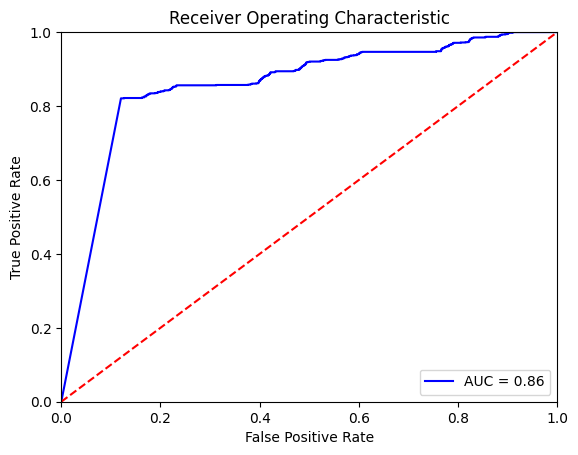

In [17]:
import sklearn.metrics as metrics
probs = wnb.predict_log_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
probs_pd = pd.DataFrame(probs)
probs_pd.to_csv('/content/drive/MyDrive/NUS/CS5340/HI_Small_Trans_Naive_Bayes_Proba.csv', index=False)

In [26]:
probs_pd.head(10)

,0,1
0,0.0,-42937.277074
1,0.0,-42851.153862
2,0.0,-78258.911535
3,0.0,-42851.153862
4,0.0,-78258.911535
5,0.0,-42937.277074
6,0.0,-42851.153862
7,0.0,-78258.911535
8,0.0,-42937.277074
9,0.0,-42937.277074


In [20]:
from sklearn.utils import resample

train_df = pd.concat([pd.DataFrame(x_train), pd.DataFrame(y_train)],axis=1)
class_counts = train_df['Is Laundering'].value_counts()
df_majority = train_df[train_df['Is Laundering'] == 0]
df_minority = train_df[train_df['Is Laundering'] == 1]
df_majority_upsampled = resample(df_minority, replace=True, n_samples=class_counts[0])
df_balanced = pd.concat([df_majority_upsampled, df_majority])
#print(df_balanced)
x_train, y_train = df_balanced.iloc[:, :-1], df_balanced.iloc[:, [-1]]


In [21]:
wnb.fit(x_train, y_train)
y_pred = wnb.predict(x_test)
print_metrics(y_pred, y_test)

<ipython-input-7-22ad8a97762c>:218: DataConversionWarning: A column-vector y was passed when a 1d array was expected.
  warnings.warn(


F1 Score: 0.013107559943989721
F1 Score unweighted: 0.8135501303915036
auc:  0.8469427172086165
[[931516 136533]
 [   197    908]]
0.006606471140343856
0.8217194570135746


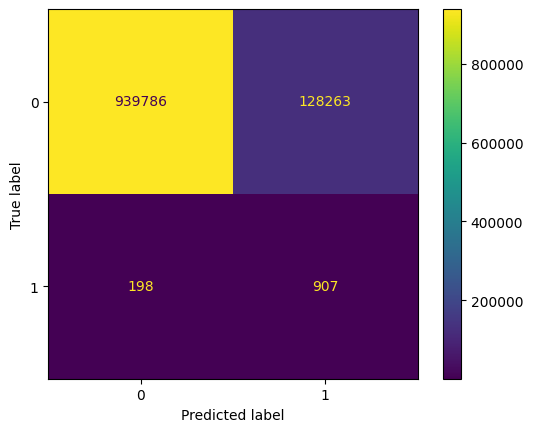

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=np.array([[939786,128263],[198,907]]))
# Then just plot it:
disp.plot()
# And show it:
plt.show()